In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from scipy.stats import pearsonr

from Models import Lap_Sim_Funcs as lsf
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

List of F1 Races from the testing period (post Apr 2024)

'Miami Grand Prix', 'Emilia Romagna Grand Prix', 'Monaco Grand Prix', 'Canadian Grand Prix', 'Spanish Grand Prix',

'Austrian Grand Prix', 'British Grand Prix', 'Hungarian Grand Prix', 'Belgian Grand Prix', 'Dutch Grand Prix',

'Italian Grand Prix', 'Azerbaijan Grand Prix', 'Singapore Grand Prix', 'United States Grand Prix', 'Mexico City Grand Prix',

'Sao Paulo Grand Prix', 'Las Vegas Grand Prix', 'Qatar Grand Prix', 'Abu Dhabi Grand Prix'

List of Drivers from the testing period (post May 2024)

'ALB', 'ALO', 'BOT', 'GAS', 'HAM', 'HUL', 'LEC', 'MAG', 'NOR', 'OCO', 'PER', 'PIA', 'RIC', 'RUS', 'SAI', 'SAR', 'STR', 'TSU', 'VER', 'ZHO', 'COL', 'BEA', 'LAW'

Modify the inputs in the following cell as per the available data in the testing period

In [2]:
#Input Cell

vw_race = 'United States Grand Prix'   # The race to be viewed
drv_lst = ['VER', 'NOR', 'LEC', 'PIA'] # Driver performances to be viewed (Recommended to have 4 or fewer)

nlaps = 20 #Laps after nlaps are simulated (Default: 20)

In [3]:
# Stage 1 LSTM Model Definition
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Parameters
input_size = 16 
hidden_size = 32
num_layers = 3
output_size = 3 

spd_model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Stage 2 LSTM Model Definition
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Parameters
input_size = 23 
hidden_size = 32
num_layers = 3
output_size = 3

pos_model = LSTMModel(input_size, hidden_size, num_layers, output_size)

In [4]:
#Data Input

df = pd.read_csv('Data/F1_Sector_Dataset.csv')

race, qual, drql, drvr = lsf.preprocess_spd_model(df)

test_df = race.loc[race['Date'] >= '2024-05-01'].copy().reset_index(drop = True)

tab = lsf.process_laps('Models/mean_lstm_32_3.pth', spd_model, test_df, qual, nlaps) #Stage 1 LSTM Execution

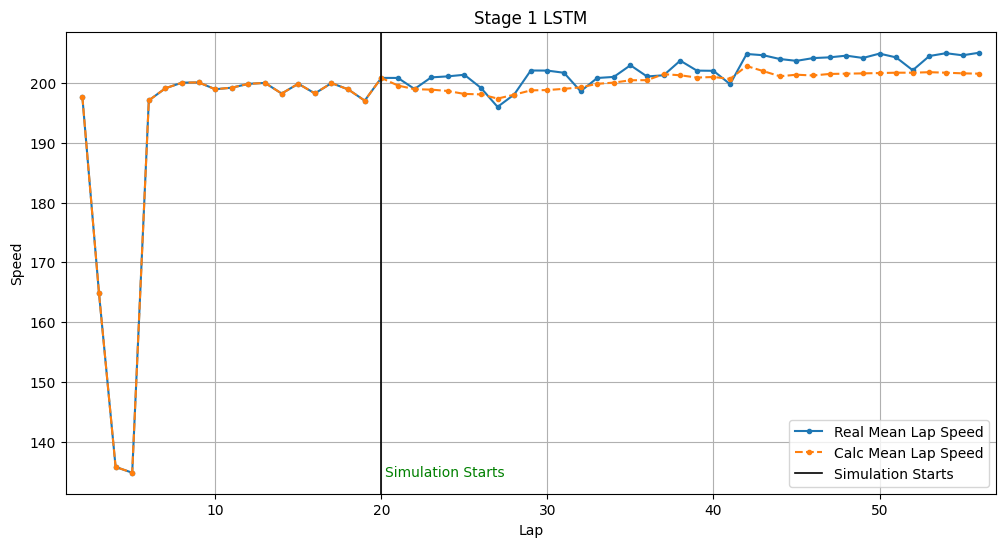

In [5]:
# Stage 1 Metrics Visualization

spd_dsp = tab.loc[tab['Race'] == vw_race].reset_index(drop = True)
mean_val = spd_dsp['Err_Lap_Spd'].mean()

plt.figure(figsize=(12, 6))
plt.plot(spd_dsp['Lap'], spd_dsp['Real_Spd'], label='Real Mean Lap Speed', linestyle='-', marker = '.')
plt.plot(spd_dsp['Lap'], spd_dsp['Calc_Spd'], label='Calc Mean Lap Speed', linestyle='--', marker = '.')
plt.xlabel('Lap')
plt.ylabel('Speed')
plt.title('Stage 1 LSTM')

plt.axvline(x=nlaps, color='black', linestyle='-', linewidth = 1.2, label='Simulation Starts')
plt.text(nlaps + 0.2, max(spd_dsp['Real_Spd'].min(), spd_dsp['Calc_Spd'].min()), 'Simulation Starts',
         verticalalignment='center', horizontalalignment='left', color='green')

plt.xlim(spd_dsp['Lap'].min() - 1, spd_dsp['Lap'].max() + 1)

plt.legend()
plt.grid(True)



plt.show()


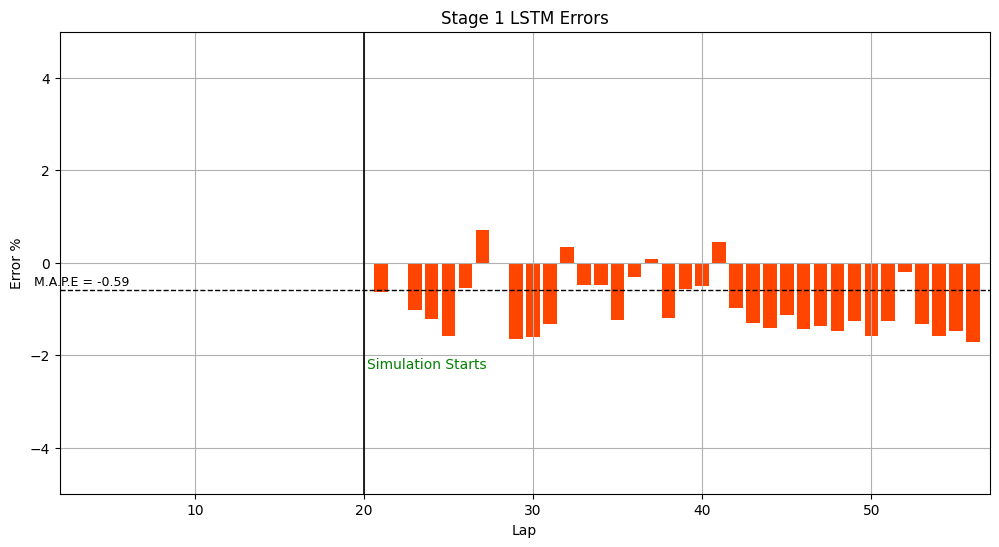

In [6]:
# Stage 1 Error Visualization

plt.figure(figsize=(12, 6))
plt.bar(spd_dsp['Lap'], spd_dsp['Err_Lap_Spd'], label = 'Real Speed', color = 'orangered')


plt.xlabel('Lap')
plt.ylabel('Error %')
plt.title('Stage 1 LSTM Errors')

plt.axvline(x=nlaps, color='black', linestyle='-', linewidth = 1.2, label='Simulation Starts')
plt.axhline(y = mean_val, color='black', linestyle='--', linewidth = 1, label = 'M.A.P.E')

plt.text(x=0.5, y = mean_val + 0.1, s=f'M.A.P.E = {mean_val:.2f}', color='black', fontsize=9)

plt.text(nlaps + 0.2, (spd_dsp['Err_Lap_Spd'].min() - 0.5), 'Simulation Starts',
         verticalalignment='center', horizontalalignment='left', color='green')


plt.xlim(spd_dsp['Lap'].min(), spd_dsp['Lap'].max()+1)
plt.ylim(min(spd_dsp['Err_Lap_Spd'].min() - 1, -5), max(spd_dsp['Err_Lap_Spd'].max() + 1, 5))

#plt.legend()
plt.grid(True)

In [7]:
drv_race = lsf.preprocess_pos_model(tab, race, qual, drql, drvr)

test_df = drv_race.loc[drv_race['Date'] >= '2024-05-01'].copy().reset_index(drop = True)

prg = lsf.driver_laps('Models/pos_lstm_32_3.pth', pos_model, test_df, nlaps) #Stage 2 LSTM Execution

In [8]:

pos_dsp = prg.loc[(prg['Race'] == vw_race) & (prg['Driver'].isin(drv_lst))].reset_index(drop = True)

dsp_drvr = 'VER' #Error Metrics for an arbitrarily chosen driver

drv_dsp = prg.loc[(prg['Race'] == vw_race) & (prg['Driver'] == dsp_drvr)].reset_index(drop = True) 

err_sec = drv_dsp['Err_Drv_Spd'].mean()
err_pos = drv_dsp['Err_Position'].mean()


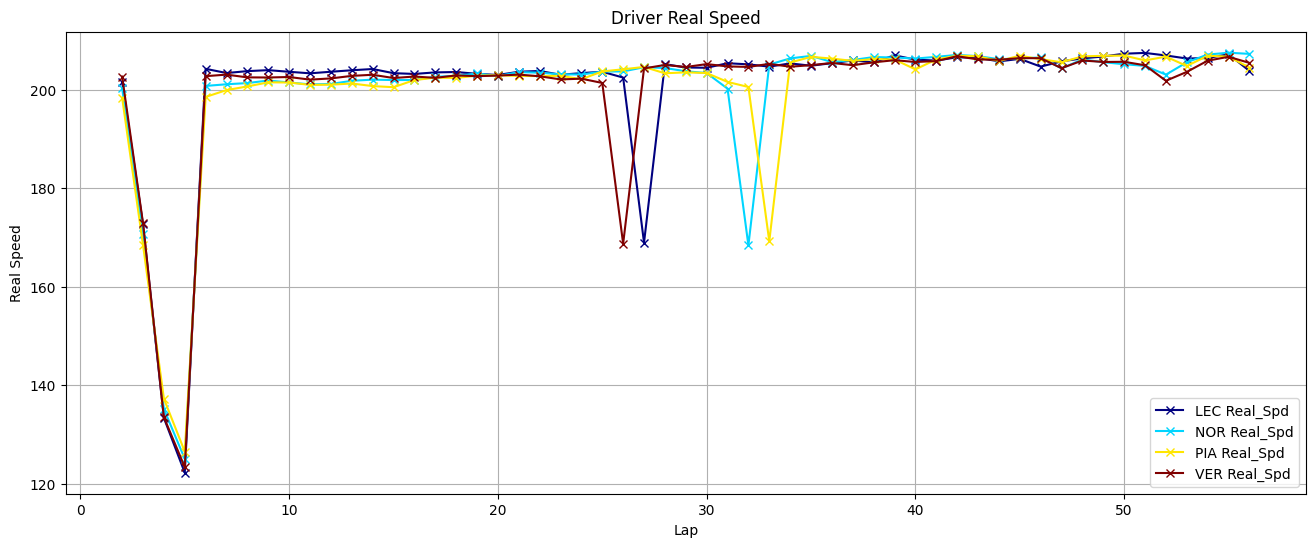

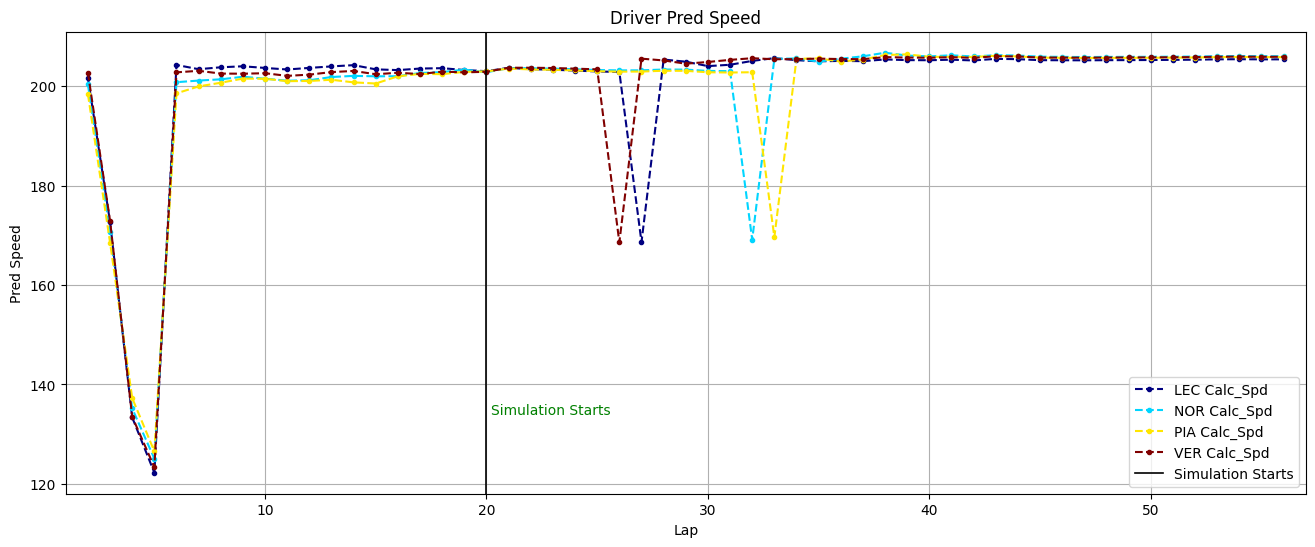

In [9]:
# Stage 2 Metrics(Speed) Visualization

drivers = pos_dsp['Driver'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(drivers)))  # Using a colormap for color assignment

plt.figure(figsize=(16, 6))

for driver, color in zip(drivers, colors):
    
    driver_data = pos_dsp[pos_dsp['Driver'] == driver]

    plt.plot(driver_data['Lap'], driver_data['Drv_Real_Spd'], label=f'{driver} Real_Spd', marker='x', color=color)

plt.title('Driver Real Speed')
plt.xlabel('Lap')
plt.ylabel('Real Speed')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(16, 6))

for driver, color in zip(drivers, colors):
    
    driver_data = pos_dsp[pos_dsp['Driver'] == driver]

    plt.plot(driver_data['Lap'], driver_data['Drv_Calc_Spd'], label=f'{driver} Calc_Spd', marker='.', linestyle='--', color=color)

plt.axvline(x=nlaps, color='black', linestyle='-', linewidth = 1.2, label='Simulation Starts')
plt.text(nlaps + 0.2, max(spd_dsp['Real_Spd'].min(), spd_dsp['Calc_Spd'].min()), 'Simulation Starts',
         verticalalignment='center', horizontalalignment='left', color='green')

plt.xlim(spd_dsp['Lap'].min() - 1, spd_dsp['Lap'].max() + 1)

plt.title('Driver Pred Speed')
plt.xlabel('Lap')
plt.ylabel('Pred Speed')
plt.legend()
plt.grid(True)
plt.show()


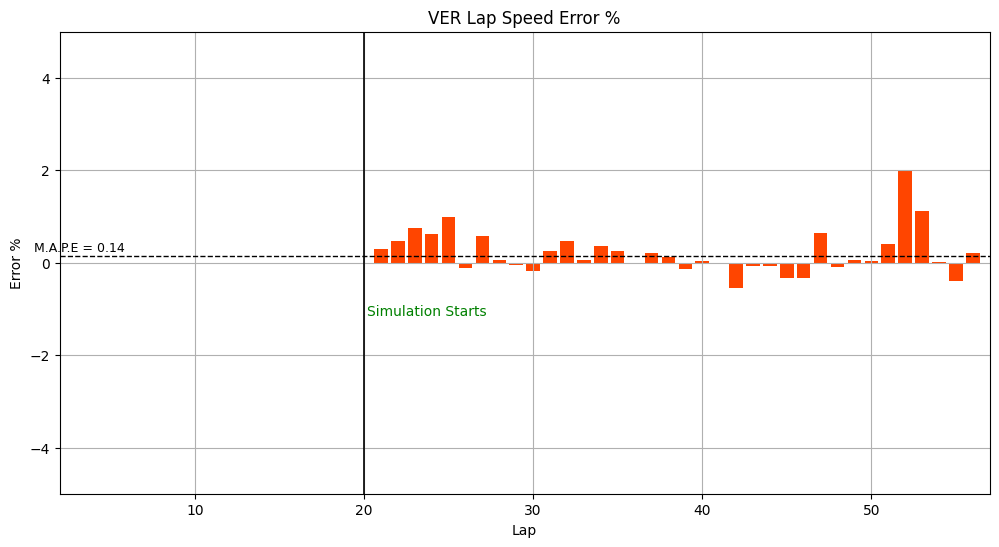

In [10]:
# Stage 2 Errors(Speed) Visualization

plt.figure(figsize=(12, 6))
plt.bar(drv_dsp['Lap'], drv_dsp['Err_Drv_Spd'], label = 'Real Speed', color = 'orangered')


plt.xlabel('Lap')
plt.ylabel('Error %')
plt.title(dsp_drvr + ' Lap Speed Error %')

plt.axvline(x=nlaps, color='black', linestyle='-', linewidth = 1.2, label='Simulation Starts')
plt.axhline(y = err_sec, color='black', linestyle='--', linewidth = 1, label = 'M.A.P.E')

plt.text(x=0.5, y = err_sec + 0.1, s=f'M.A.P.E = {err_sec:.2f}', color='black', fontsize=9)

plt.text(nlaps + 0.2, (drv_dsp['Err_Drv_Spd'].min() - 0.5), 'Simulation Starts',
         verticalalignment='center', horizontalalignment='left', color='green')


plt.xlim(drv_dsp['Lap'].min(), drv_dsp['Lap'].max()+1)
plt.ylim(min(drv_dsp['Err_Drv_Spd'].min() - 1, -5), max(drv_dsp['Err_Drv_Spd'].max() + 1, 5))

plt.grid(True)

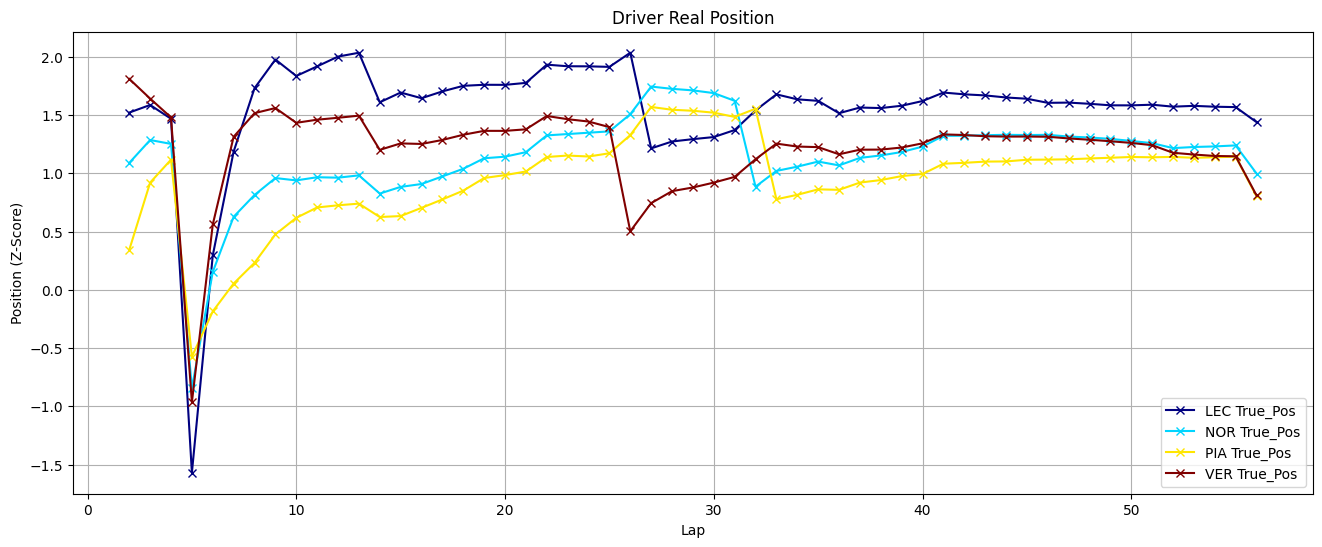

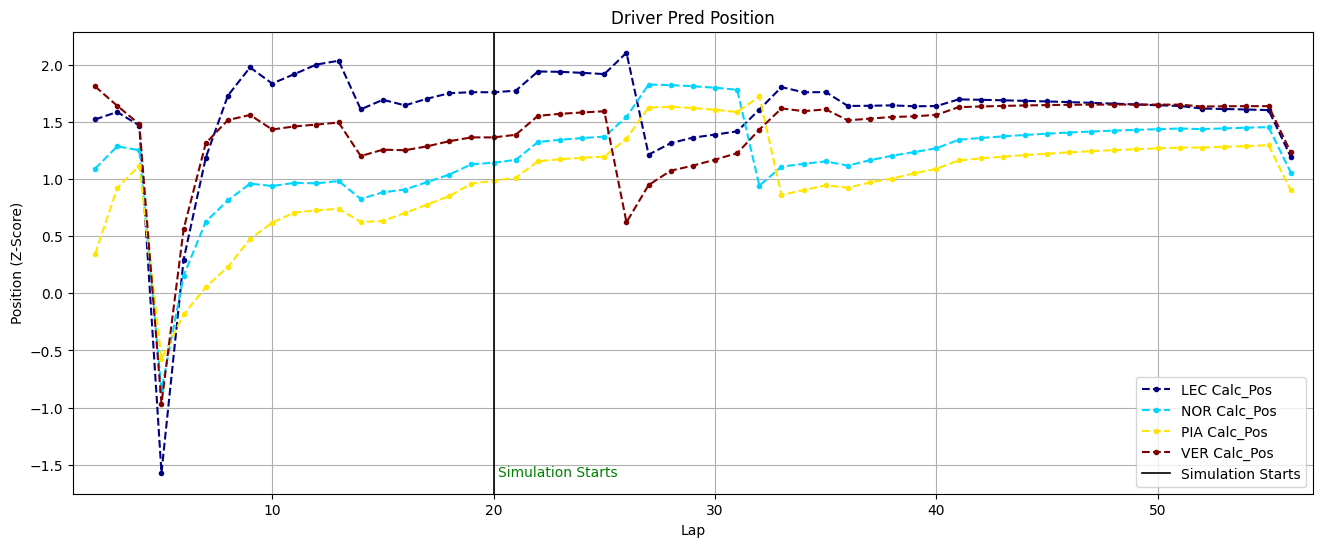

In [11]:
# Stage 2 Metrics(Position) Visualization

drivers = pos_dsp['Driver'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(drivers)))

plt.figure(figsize=(16, 6))

for driver, color in zip(drivers, colors):
    
    driver_data = pos_dsp[pos_dsp['Driver'] == driver]

    plt.plot(driver_data['Lap'], driver_data['Position_T'], label=f'{driver} True_Pos', marker='x', color=color)

plt.title('Driver Real Position')
plt.xlabel('Lap')
plt.ylabel('Position (Z-Score)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(16, 6))

for driver, color in zip(drivers, colors):

    driver_data = pos_dsp[pos_dsp['Driver'] == driver]

    plt.plot(driver_data['Lap'], driver_data['Position_P'], label=f'{driver} Calc_Pos', marker='.', linestyle='--', color=color)

plt.axvline(x=nlaps, color='black', linestyle='-', linewidth = 1.2, label='Simulation Starts')
plt.text(nlaps + 0.2, pos_dsp['Position_P'].min(), 'Simulation Starts',
         verticalalignment='center', horizontalalignment='left', color='green')

plt.xlim(pos_dsp['Lap'].min() - 1, pos_dsp['Lap'].max() + 1)
plt.title('Driver Pred Position')
plt.xlabel('Lap')
plt.ylabel('Position (Z-Score)')
plt.legend()
plt.grid()
plt.show()

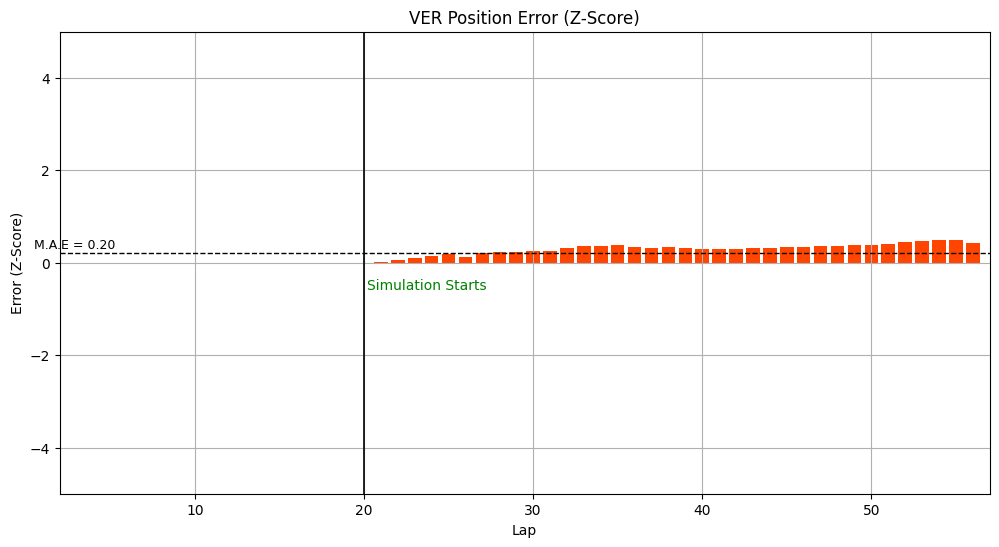

In [12]:
# Stage 2 Errors(Position) Visualization

plt.figure(figsize=(12, 6))
plt.bar(drv_dsp['Lap'], drv_dsp['Err_Position'], label = 'Position Error', color = 'orangered')


plt.xlabel('Lap')
plt.ylabel('Error (Z-Score)')
plt.title(dsp_drvr + ' Position Error (Z-Score)')

plt.axvline(x=nlaps, color='black', linestyle='-', linewidth = 1.2, label='Simulation Starts')
plt.axhline(y = err_pos, color='black', linestyle='--', linewidth = 1, label = 'M.A.E')

plt.text(x=0.5, y = err_pos + 0.1, s=f'M.A.E = {err_pos:.2f}', color='black', fontsize=9)

plt.text(nlaps + 0.2, (drv_dsp['Err_Position'].min() - 0.5), 'Simulation Starts',
         verticalalignment='center', horizontalalignment='left', color='green')


plt.xlim(drv_dsp['Lap'].min(), drv_dsp['Lap'].max()+1)
plt.ylim(min(drv_dsp['Err_Position'].min() - 1, -5), max(drv_dsp['Err_Position'].max() + 1, 5))

plt.grid(True)

In [13]:
std = lsf.rank_drivers(prg) # Post Race Standing Inference
rce_std = std.loc[std['Race'] == vw_race].reset_index(drop = True)

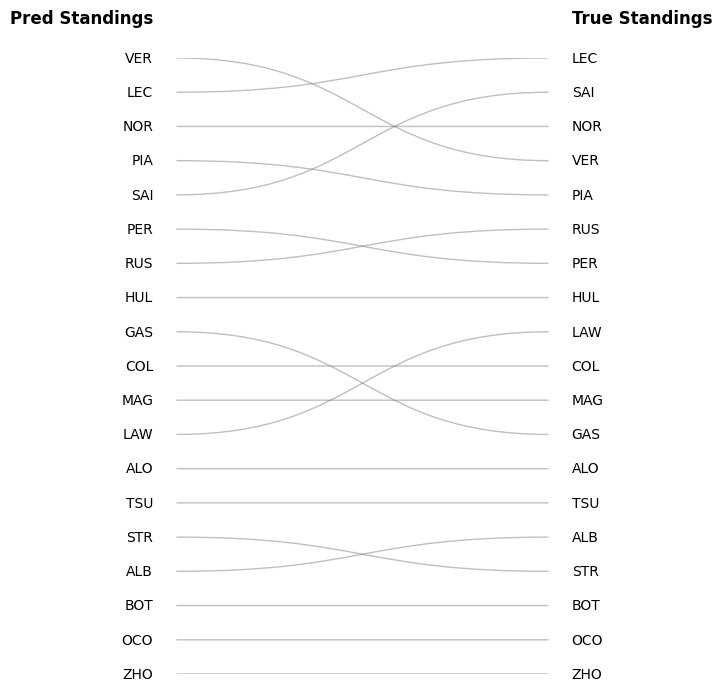

In [14]:
# Race Predicted v/s Actual Standings

fig, ax = plt.subplots(figsize=(6, 8))
ax.axis('off')

x_left = 0.1
x_right = 0.9
n_drivers = len(rce_std)

df_left = rce_std.sort_values(by = ['Standing_P'], ascending = False).reset_index(drop=True)
df_left['y_left'] = np.linspace(0, 1, n_drivers)
df_right = rce_std.sort_values(by = ['Standing_T'], ascending = False).reset_index(drop=True)
df_right['y_right'] = np.linspace(0, 1, n_drivers)

driver_positions = {}
for idx, row in rce_std.iterrows():
    driver = row['Driver']
    y_left = df_left[df_left['Driver'] == driver]['y_left'].values[0]
    y_right = df_right[df_right['Driver'] == driver]['y_right'].values[0]
    driver_positions[driver] = {'y_left': y_left, 'y_right': y_right}

for driver, pos in driver_positions.items():
    y_left = pos['y_left']
    y_right = pos['y_right']
    
    ax.text(x_left - 0.05, y_left, driver, ha='right', va='center')
    ax.text(x_right + 0.05, y_right, driver, ha='left', va='center')

    verts = [
        (x_left, y_left),
        ((x_left + x_right) / 2, y_left),
        ((x_left + x_right) / 2, y_right),
        (x_right, y_right),
    ]
    codes = [Path.MOVETO,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             ]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=1, edgecolor='gray', alpha=0.5)
    ax.add_patch(patch)

ax.text(x_left - 0.05, 1.05, 'Pred Standings', ha='right', va='bottom', fontsize=12, fontweight='bold')
ax.text(x_right + 0.05, 1.05, 'True Standings', ha='left', va='bottom', fontsize=12, fontweight='bold')

plt.show()

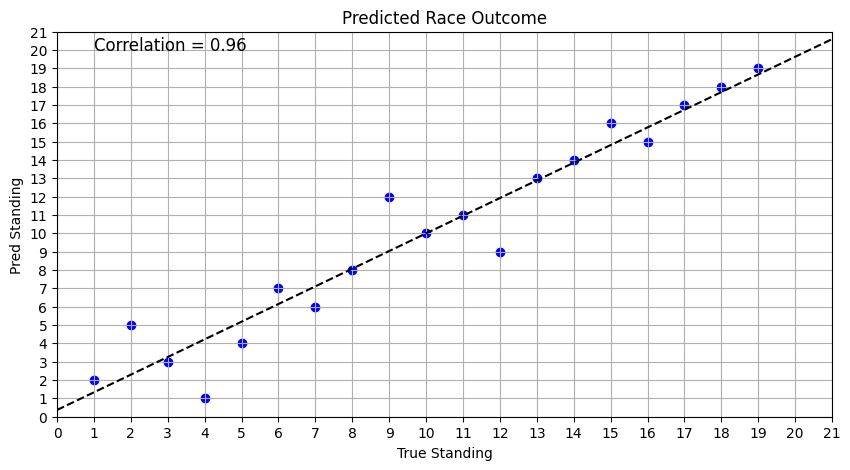

In [15]:
# Post Race Correlation

dsp_rce = rce_std.loc[rce_std['Race'] == vw_race].reset_index(drop = True)

x = dsp_rce['Standing_T']
y = dsp_rce['Standing_P']

corr_coef, _ = pearsonr(x, y)

plt.figure(figsize=(10, 5))
plt.scatter(x, y, color='blue', label='Data Points')

slope, intercept = np.polyfit(x, y, 1)

x_line = np.linspace(0, 21, 100) 
y_line = slope * x_line + intercept

plt.plot(x_line, y_line, color='black', linestyle='--', label='Regression Line')

plt.xlabel('True Standing')
plt.ylabel('Pred Standing')
plt.title('Predicted Race Outcome')

x_text = 1
y_text = 20
plt.text(x_text, y_text, f"Correlation = {corr_coef:.2f}", fontsize=12, color='black')

plt.xlim(0, 21)
plt.ylim(0, 21)
plt.xticks(range(0, 22))
plt.yticks(range(0, 22))
plt.grid()
plt.show()